In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utilities.utils import *

from src.plotting import Plotter
from src.gl_solver import GLSolver
from src.parameters_init import ParametersInit
from src.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
Nx=4
Ny=4

Lx=30 
Ly=30

T_end = 1
dt = 0.005

N_ITERATIONS = int(T_end / dt)

In [4]:
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=2*2, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=100, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 11104.27it/s]

Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [400 400 400 400 400 400 400 400]
A.shape=(1, 200, 4, 4),
Myu.shape=(1, 200, 4, 4),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


In [5]:
def output_plot(data, mem_rat, save_fig=False, file_name="A_in_norm_80%04d.png"):
    fig = plt.figure(1, figsize=(6.5, 6.5))
    for index in tqdm(range(mem_rat)):
        if index % 2 == 0:
            plt.clf()
            plt.imshow(data[index, :, :], origin='lower', vmax=0.9*np.max(data))
            plt.colorbar()
            if save_fig:
                filename = file_name % (index/2)
                plt.savefig(filename)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 67.02it/s]


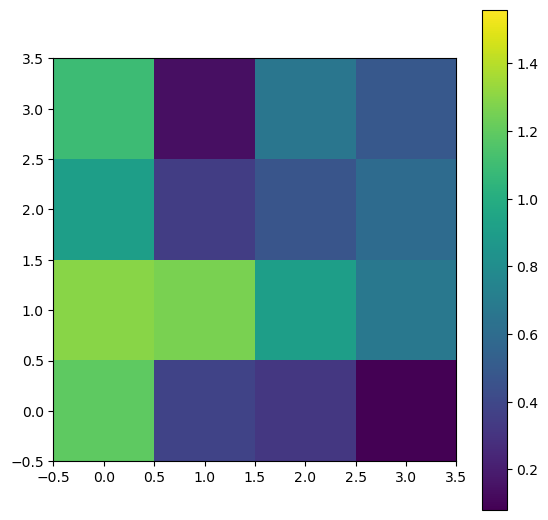

In [6]:
output_plot(A_norm, mem_rate)

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

In [7]:
snn_layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]

x = np.linspace(0, Lx, Nx).flatten()[:, None]
y = np.linspace(0, Ly, Ny).flatten()[:, None]
t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

Exact = A_original.squeeze(0)

X, T, Y = np.meshgrid(x, t, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()
u_star = np.hstack([u_star.real[:, None],u_star.imag[:, None]])

In [8]:
X_star.shape, u_star.shape

((3200, 3), (3200, 2))

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [9]:
class LOSS:
  def __init__(self, x, y, t, verbose = 0):
      self.msef = nn.MSELoss()
      self.MSE = []
      self.F = []
      self.FMSE = []
      self.verbose = verbose
      self.x = x
      self.y = y
      self.t = t

  def load(self,y_pred,y_real):
      self.y_pred = y_pred
      self.y_real = y_real
    
  def plot(self):
      fig, [upper,lower] = plt.subplots(nrows=2)
      upper.plot(self.MSE)
      upper.legend("MSE")
      upper.set_title("MSE")
      upper.set_yscale('log')
      
      lower.plot(self.FMSE)
      lower.legend("FMSE")
      lower.set_title("FMSE")
      lower.set_yscale('log')
      
      plt.show()

  def mse(self):
      loss = self.msef(self.y_pred,self.y_real)
      if(self.verbose):
        print(f"MSELOSS: {loss}")
      self.MSE.append(loss.cpu().detach().numpy())
      return loss

  def fmse(self, myu):
    f_loss = torch.mean(torch.abs(self.net_f(myu)) ** 2)
    self.FMSE.append(f_loss.cpu().detach().numpy())
    return f_loss

  def __radd__(self, other):
    if other == 0:
        return self
    else:
        return self.__add__(other) 
       
  def __add__(self, L):
    l = LOSS(self.x,self.y,self.t, verbose = self.verbose)
    if "y_pred" in dir(self):
        l.load(self.y_pred, self.y_real)
    if "y_pred" in dir(L):
        l.load(L.y_pred, L.y_real)
    l.MSE = self.MSE + L.MSE
    l.FMSE = self.FMSE + L.FMSE
    l.F = self.F + L.F
    return l

  def net_f(self, myu, verbose = 0):
        torch.autograd.set_detect_anomaly(True)
        x,y,t = self.x, self.y, self.t
        
        ru = self.y_pred[:,0]
        iu = self.y_pred[:,1]

        (ru_t, ru_x, ru_y) = torch.autograd.grad(ru, (t, x, y), grad_outputs=torch.ones_like(ru), create_graph=True, retain_graph=True)
        (iu_t, iu_x, iu_y) = torch.autograd.grad(iu, (t, x, y), grad_outputs=torch.ones_like(iu), create_graph=True, retain_graph=True)

        (ru_xx,) = torch.autograd.grad(ru_x, (x), grad_outputs=torch.ones_like(ru_x), create_graph=True)
        (iu_xx,) = torch.autograd.grad(iu_x, (x), grad_outputs=torch.ones_like(iu_x), create_graph=True)

        (ru_yy,) = torch.autograd.grad(ru_y, (y), grad_outputs=torch.ones_like(ru_y), create_graph=True)
        (iu_yy,) = torch.autograd.grad(iu_y, (y), grad_outputs=torch.ones_like(iu_y), create_graph=True)

        u =( ru + iu * 1j).view(mem_rate, Nx, Ny)
        u_t = (ru_t + iu_t * 1j).view(mem_rate, Nx, Ny)
        u_xx =( ru_xx + iu_xx *1j).view(mem_rate, Nx, Ny)
        u_yy = (ru_yy + iu_yy *1j).view(mem_rate, Nx, Ny)

        if(verbose):
            print('u_t:',u_t)
            print('u:',u)
            print('u_xx:',u_xx)
            print('u_yy:',u_yy)
            
        f = u_t - myu*u - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u
        free_memory(u, u_t, u_xx, u_yy)

        return f
      
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [10]:
class GALAXYNET(nn.Module):
    def __init__(self, layers_list, activation_function_list = None, linm = None):
        super(GALAXYNET, self).__init__()
        self._depth = len(layers_list) - 1
        
        if activation_function_list is None:
            activation_function_list = [F.softplus for _ in range(self._depth - 1)]
            
        if linm is None:
            linm =  np.tril(np.ones(self._depth + 1, dtype = int))
        lin = linm@layers_list
        
        self._activation_function_list = activation_function_list
        
        self._Wtmx = nn.Sequential(*[torch.nn.Linear(lin[i], layers_list[i+1], dtype = torch.float64) for i in range(self._depth)])
        self._linm = linm
        
        self.optimizer = torch.optim.Adam( params = self._Wtmx.parameters(), lr=0.01 )    
        
    def forward(self, x):
        layers = [x,self._Wtmx[0](x)]
        for i in range(1, self._depth):
            layers[i] = self._activation_function_list[i-1](layers[i])
            ind = self._linm[i]
            inpind = np.where(ind)[0]
            inp = torch.concat([layers[i] for i in inpind], dim=1)
            layers.append(self._Wtmx[i](inp))
        return layers[-1]        

    def predict(self, x):
        self._Wtmx.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self.forward(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j    

    def rmsef(self, y, y_pred):
        mseloss = torch.sum((y_pred - y)**2,dim=1)
        return torch.sum(torch.sqrt(mseloss))
    
    def fastrmsetrain(self, x, y, epochs=100):
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        
        self.optimizer.zero_grad()
        L = []
        
        for _ in tqdm(range(epochs)):
            y_pred = self.forward(x)
            loss = self.rmsef(y,y_pred)
            L.append(loss.cpu().detach().numpy())
            loss.backward()   
            self.optimizer.step()
            self._Wtmx.zero_grad()       

        return L       

    def fastrmsebatchtrain(self, x, y, epochs=100, batch_size = 64):
        from torch.utils.data import DataLoader

        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        dataloader = DataLoader(dataset = torch.hstack((x,y)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        L = []
        
        import math
        batchiter = (epochs * batch_size)  // x.size()[0]
        epochs =  batchiter * math.ceil(x.size()[0] / batch_size)
        
        pbar = tqdm(total=epochs)
        try:
            for _ in range(batchiter):
                for i, tmp in enumerate(dataloader):
                    (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                    X = torch.stack((tmpx,tmpy,tmpt)).T
                    U = torch.stack((tmpu_real, tmpu_img)).T

                    y_pred = self.forward(X)
                    loss = self.rmsef(y_pred,U)
                    L.append(loss.cpu().detach().numpy())
                    loss.backward()
                    self.optimizer.step()
                    self._Wtmx.zero_grad()
                    # Update the progress bar
                    pbar.update(1)
        except:
            pass
        finally:
            # Close the progress bar
            pbar.close()          
        return L       

In [11]:
class GALAXYPINN(GALAXYNET):
    def __init__(self,*args,**kwargs):
        super(GALAXYPINN, self).__init__(*args,**kwargs)
#         myu = torch.randn(4, 2, dtype=torch.float64).to(device)
#         myu = nn.Parameter(myu)
#         self._Wtmx.register_parameter('myu', myu)
#         self.myuparam = myu
#         myu = transform_and_stack(myu, 4, 200).to(device).clone().requires_grad_(True)
#         self.myu = myu.view(200, 4, 4)
        self.myureset()
    
    def myureset(self):
        myu = torch.randn(mem_rate, Nx, Ny, dtype=torch.float64).to(device)
        myu = torch.abs(myu)
        myu = nn.Parameter(myu)
        self._Wtmx.register_parameter('myu', myu)
        self.myuparam = myu
        self.myu = myu
        
    def train(self, x, y, epochs=100, verbose = 0, mode = 1, speed = 0):
        x = torch.tensor(x, dtype = torch.float64, requires_grad=True).to(device)
        y = torch.tensor(y, dtype = torch.float64, requires_grad=True).to(device)

        self.optimizer.zero_grad()
        tuplex = tuple(x.T)
        L = LOSS(*tuplex, verbose= verbose)
        x = torch.stack(tuplex).T

        for _ in tqdm(range(epochs)):

          L.load(self.forward(x),y)
          if(mode == 1 or (mode == 3 and not _%2)):
              if not speed: L.fmse(self.myu)
              L.mse().backward(retain_graph=True)
          if(mode == 2 or (mode == 3 and _%2)):              
              if not speed: L.mse()
              L.fmse(self.myu).backward(retain_graph=True)          

          self.optimizer.step()
          self._Wtmx.zero_grad()

        return L  
    
    def myutrain(self, x, verbose = 0, zero_grad = True, epochs=100, lr = 0.01):
        x = torch.tensor(x, dtype = torch.float64, requires_grad=True).to(device)
        myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=lr ) 
        myuoptimizer.zero_grad()
            
        tuplex = tuple(x.T)
        L = LOSS(*tuplex, verbose= verbose)
        x = torch.stack(tuplex).T
        
        for _ in tqdm(range(epochs)):
            L.load(self.forward(x),1)
            L.fmse(self.myu).backward(retain_graph=True)

            myuoptimizer.step()

        return L
        

In [12]:
device='cpu'
import torch
torch.cuda.empty_cache()
torch.manual_seed(0)
net = GALAXYPINN([3,8,32,64,32,8,2]).to(device)

In [13]:
L1 = net.fastrmsebatchtrain(x = X_star, y = u_star, epochs = 100000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:34<00:00, 1053.04it/s]


In [14]:
torch.autograd.set_detect_anomaly(False)
net.optimizer.param_groups[0]['lr'] = 0.001
L2 = net.fastrmsebatchtrain(x = X_star, y = u_star, epochs = 100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:44<00:00, 956.02it/s]


In [15]:
# net.optimizer.param_groups[0]['lr'] = 0.0001
# L3 = net.fastmsebatchtrain(x = X_star, y = u_star, epochs = 100000)

Text(0.5, 1.0, 'Training of the AllInputNet \n lr=0.01')

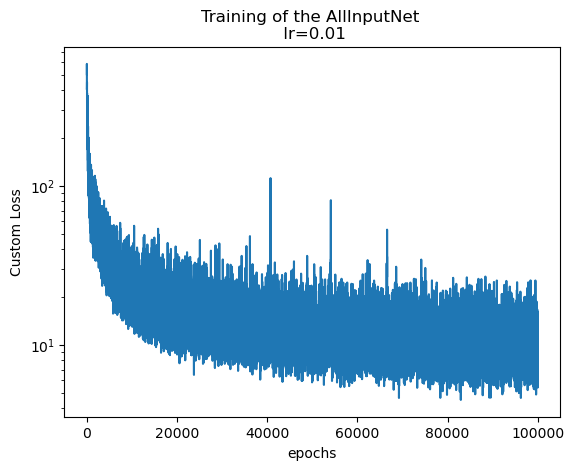

In [16]:
plt.plot(L1)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.01')

Text(0.5, 1.0, 'Training of the AllInputNet \n lr=0.001')

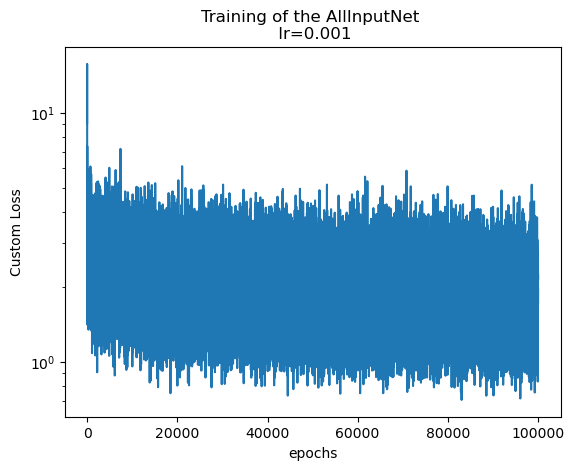

In [17]:
plt.plot(L2)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.001')

In [18]:
net.myureset()

In [19]:
mL1 = net.myutrain(X_star, lr = 10, epochs = 10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.25s/it]


Text(0, 0.5, 'FMSE')

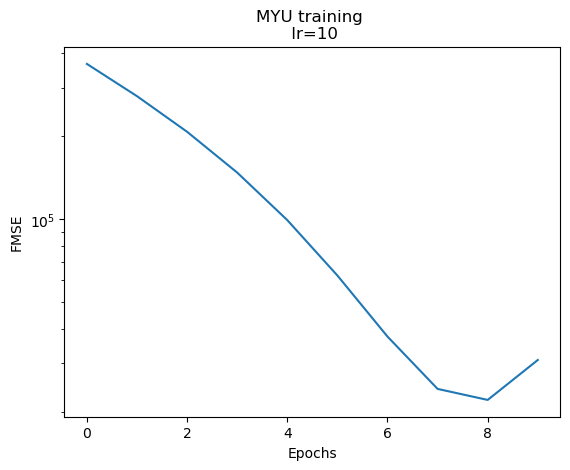

In [20]:
plt.plot(mL1.FMSE)
plt.yscale('log')
plt.title('MYU training \n lr=10')
plt.xlabel('Epochs')
plt.ylabel('FMSE')

In [21]:
mL2 = net.myutrain(X_star, lr = 3, epochs = 10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.14s/it]


Text(0, 0.5, 'FMSE')

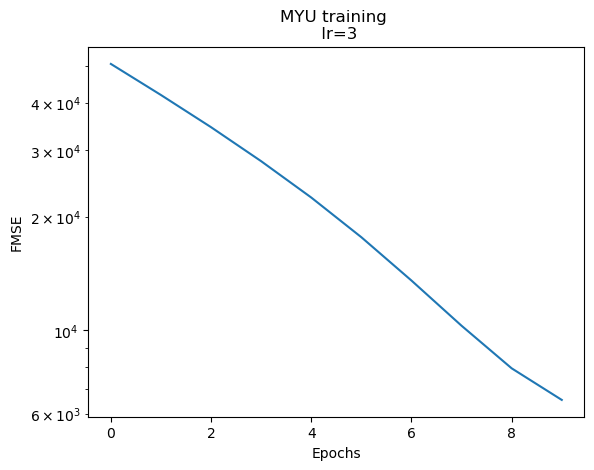

In [22]:
plt.plot(mL2.FMSE)
plt.yscale('log')
plt.title('MYU training \n lr=3')
plt.xlabel('Epochs')
plt.ylabel('FMSE')

In [23]:
mL3 = net.myutrain(X_star, lr = 1, epochs = 10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.68s/it]


Text(0, 0.5, 'FMSE')

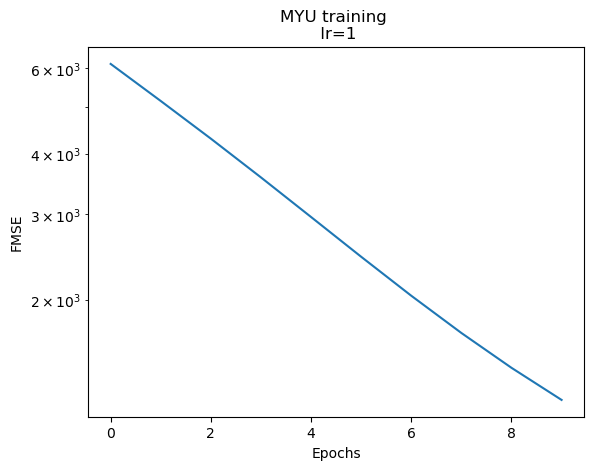

In [24]:
plt.plot(mL3.FMSE)
plt.yscale('log')
plt.title('MYU training \n lr=1')
plt.xlabel('Epochs')
plt.ylabel('FMSE')

In [25]:
mL4 = net.myutrain(X_star, lr = 0.3, epochs = 10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.65s/it]


Text(0, 0.5, 'FMSE')

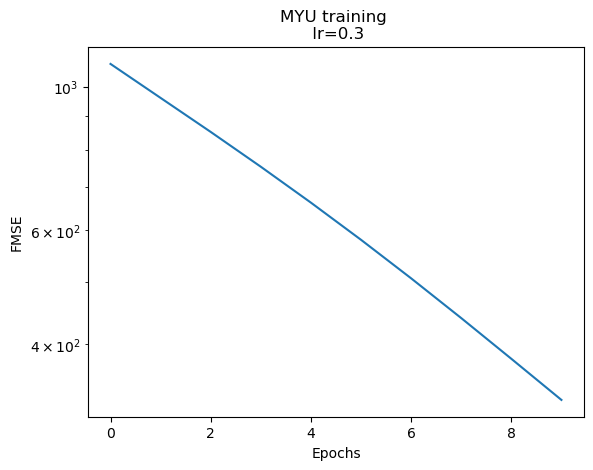

In [26]:
plt.plot(mL4.FMSE)
plt.yscale('log')
plt.title('MYU training \n lr=0.3')
plt.xlabel('Epochs')
plt.ylabel('FMSE')

In [28]:
ploter = Plotter(net.myu.cpu().detach().numpy())

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

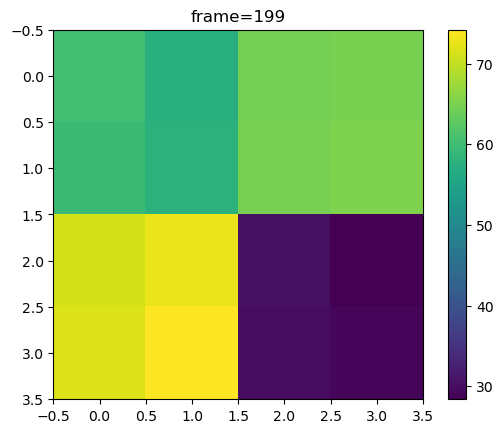

In [29]:
ploter.output_animation(mem_rate, save_gif=True, file_name=r"galaxynet_myu_with_plots_pred.gif")

In [30]:
ploter = Plotter(myu_original.squeeze(0))

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

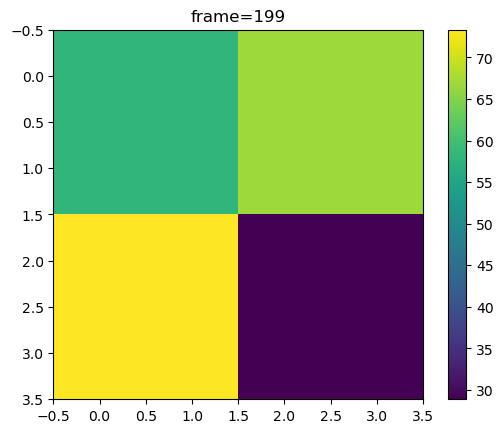

In [31]:
ploter.output_animation(mem_rate, save_gif=True, file_name=r"galaxynet_myu_with_plots_original.gif")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.22it/s]


GIF successfully saved at galaxynet_myu_with_plots.gif


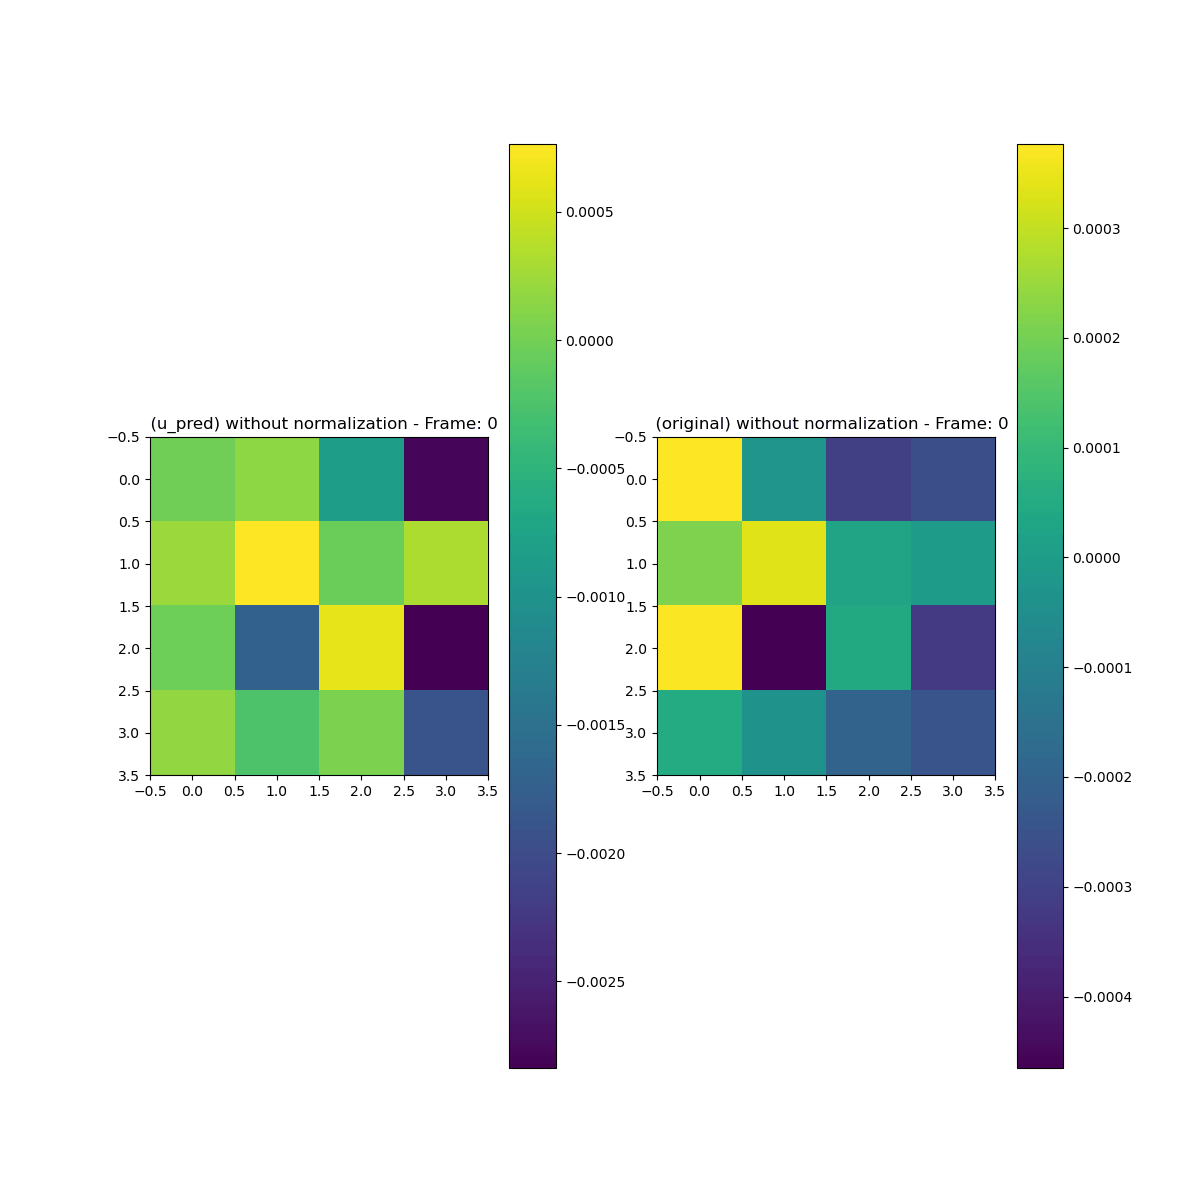

In [32]:
path="galaxynet_myu_with_plots"
create_gifs(
    memory_rate=mem_rate,
    u_pred=net.predict(X_star),
    original=A_original,
    save=True,
    path_for_gif=path+".gif",
    duration=500,
    title=" "
)
Image(filename=path+".gif")

In [33]:
gif = imageio.mimread(path+".gif", memtest=False)
nums = len(gif)
print("Total {} frames in the gif {}!".format(nums, path+".gif"))

Total 100 frames in the gif galaxynet_myu_with_plots.gif!


In [34]:
# Convert form BGR to RGB
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in gif]

# Save frames to video
out = cv2.VideoWriter(path+'.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 2, (imgs[0].shape[1], imgs[0].shape[0]))

for img in imgs:
    out.write(img)

out.release()

[ WARN:0@476.101] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements
